<a href="https://colab.research.google.com/github/pawan070bct27/Lung_cancer_Kflod_SVM/blob/main/SVM_of_k_fold_of_dataset_lung_PCA_xy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing necessary libraries

In [1]:

from keras.models import Sequential
from sklearn import svm, metrics
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import TensorBoard
from keras.layers import Dense, Flatten, Convolution2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from keras.utils import np_utils
from keras.layers import AveragePooling2D
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, accuracy_score, precision_score, recall_score
from collections import deque
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import time
import pandas as pd
import numpy as np
import tensorflow as tf
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Loading the dataset

In [2]:

data_xy = np.load('train_xy.npy')
label_xy = np.load('train_label_xy.npy')

data_yz = np.load('train_yz.npy')
label_yz = np.load('train_label_yz.npy')

data_xz = np.load('train_xz.npy')
label_xz = np.load('train_label_xz.npy')

In [3]:
#standard scale the data
sc = StandardScaler()
sc.fit(data_xy)
data_xy_std = sc.transform(data_xy)
sc.fit(data_xz)
data_xz_std = sc.transform(data_xz)
sc.fit(data_yz)
data_yz_std = sc.transform(data_yz)

In [4]:
#Making a list of dictionaries
datasets = [
{
    'name': 'XY',
    'data': data_xy_std,
    'label': label_xy
},
{
    'name': 'YZ',
    'data': data_yz_std,
    'label': label_yz
},
{
    'name': 'XZ',
    'data': data_xz_std,
    'label': label_xz
  
}
]

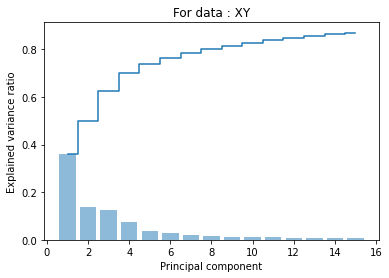

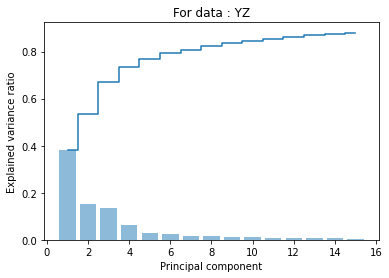

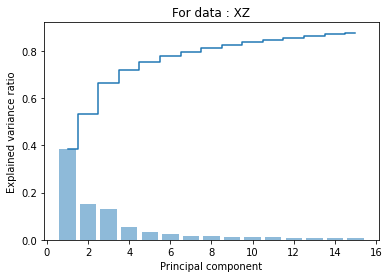

In [5]:
#PCA visualization
for i in datasets:
  visualize_pca_obj = PCA()
  visualize_pca = visualize_pca_obj.fit_transform(i['data'])
  plt.bar(range(1, 16), visualize_pca_obj.explained_variance_ratio_[:15], alpha=0.5, align='center')
  plt.step(range(1, 16), np.cumsum(visualize_pca_obj.explained_variance_ratio_)[:15], where='mid')
  plt.ylabel('Explained variance ratio')
  plt.xlabel('Principal component')
  plt.title('For data : ' + str(i['name']))
  plt.show()

In [6]:
#defining a function for splitting datasets
def split_datasets():
  new_data = m['data'].reshape(167,6,3136)
  new_label = m['label'].reshape(167,6,1)
  X_train, X_test, y_train, y_test = train_test_split(new_data, new_label, test_size=0.3, random_state=101, shuffle = True)

  X_train = X_train.reshape(X_train.shape[0]*6, 3136)
  y_train = y_train.reshape(y_train.shape[0]*6,)

  X_test = X_test.reshape(X_test.shape[0]*6, 3136)
  y_test = y_test.reshape(y_test.shape[0]*6,)
  return X_train, X_test, y_train, y_test

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: Accuracy of 63.39869281045751%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: Accuracy of 63.39869281045751%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: Accuracy of 63.39869281045751%
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: Accuracy of 63.39869281045751%
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: Accuracy of 63.39869281045751%
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - - Accuracy: 63.39869281045751%
-------------------------------------------------------------------

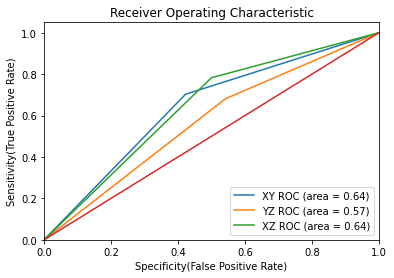

In [7]:
 #Below for loop iterates through your dataset list
speci = deque([])
sensi = deque([])
au    = deque([])
_f1score = deque([])
_accuracy = deque([])

# NAME = "Lung_cancer_typical_CNN{}".format(int(time.time()))
# tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))


for m in datasets:
# Define per-fold score containers
    acc_per_fold = []
    loss_per_fold = []
    X_train, X_test, y_train, y_test = split_datasets()
    # Merge inputs and targets
    inputs = np.concatenate((X_train, X_test), axis=0)
    targets = np.concatenate((y_train, y_test), axis=0)

    # Define the K-fold Cross Validator
    from sklearn.model_selection import KFold
    kfold = KFold(n_splits= 5, shuffle=True)

    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(inputs, targets):
      
      # Generate a print
      print('------------------------------------------------------------------------')
      print(f'Training for fold {fold_no} ...')
    
      #Create a svm Classifier
      model = svm.SVC(kernel='linear') # Linear Kernel

      #Train the model using the training sets
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      # Generate generalization metrics
      scores = metrics.accuracy_score(y_test, y_pred)
      print(f'Score for fold {fold_no}: Accuracy of {scores*100}%')
      acc_per_fold.append(scores * 100)
      # Increase fold numberå
      fold_no = fold_no + 1
    # == Provide average scores ==
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(acc_per_fold)):
      print('------------------------------------------------------------------------')
      print(f'> Fold {i+1} - - Accuracy: {acc_per_fold[i]}%')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
    print('------------------------------------------------------------------------')
    
    y_pred=model.predict(X_test)
    # from sklearn.metrics import confusion_matrix
    # cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
    # window.append(cm)
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
 #Compute precision   
    raw_speci= precision_score(y_test, y_pred)
    speci.append(((raw_speci)))
#Compute recall
    raw_sensi= precision_score(y_test,y_pred)
    sensi.append(((raw_sensi)))
    # sensi.append("{:.0%}".format(tpr))
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score(y_test, y_pred)
    au.append(((auc)))
#accuracy
    _acc = accuracy_score(y_test, y_pred)
    _accuracy.append((_acc))
# F1 -score
    _fscore1 = f1_score(y_test, y_pred)
    _f1score.append(((_fscore1)))

# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['name'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show() 
  # Display

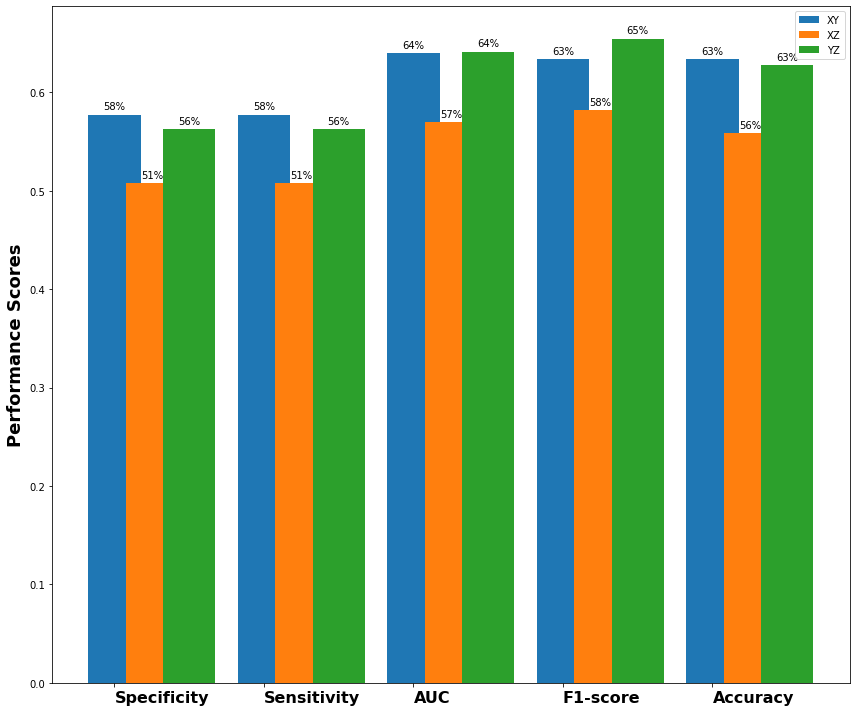

In [8]:
#Creating a grouped bar plot
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

speci = (list(speci))
sensi =  (list(sensi))
_f1score = (list(_f1score))
_accuracy =(list(_accuracy))
au = (list(au))
barWidth = 0.25
labels = ['Specificity', 'Sensitivity', 'AUC', 'F1-score', 'Accuracy']
cnn_means = [speci[0], sensi[0], au[0], _f1score[0], _accuracy[0]]
cnn1_means = [speci[1], sensi[1], au[1], _f1score[1], _accuracy[1]]
cnn2_means = [speci[2], sensi[2], au[2], _f1score[2], _accuracy[2]]


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
# Set position of bar on X axis
r1 = x
r2 = [p + barWidth for p in r1]
r3 = [p + barWidth for p in r2]
fig, ax = plt.subplots(figsize=(12,10))
rects1 = ax.bar(r1, (cnn_means), width, label='XY')
rects2 = ax.bar(r2, (cnn1_means), width, label='XZ')
rects3 = ax.bar(r3, (cnn2_means), width, label='YZ')



# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Performance Scores', fontweight='bold', fontsize = 18)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontweight='bold', fontsize = 16, horizontalalignment = 'left')
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.0%}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)


fig.tight_layout()

plt.show()